# 2016-01-15の着順と特徴量の相関

対象ファイル:
- data/previews/2016/01/15.csv
- data/results/2016/01/15.csv

目的: プレビュー情報(艇番ごとの情報 + 気象など)と着順の相関を確認する。


注意:
- 着順は小さいほど良いので、相関が負なら着順が良くなる方向。
- 結果データに欠損がある行は除外する。


In [1]:
from pathlib import Path
import pandas as pd

cwd = Path.cwd()
repo_root = cwd if (cwd / 'data').exists() else cwd.parent.parent

year = '2026'
month = '01'
day = '15'

preview_path = repo_root / 'data' / 'previews' / year / month / f'{day}.csv'
program_path = repo_root / 'data' / 'programs' / year / month / f'{day}.csv'
result_path = repo_root / 'data' / 'results' / year / month / f'{day}.csv'

preview_path.exists(), program_path.exists(), result_path.exists()


(True, True, True)

In [2]:
preview = pd.read_csv(preview_path)
programs = pd.read_csv(program_path)
results = pd.read_csv(result_path)

preview.shape, programs.shape, results.shape


((105, 53), (165, 177), (166, 100))

In [3]:
race_cols = [
    'レースコード', 'タイトル', 'レース日', 'レース場', 'レース回',
    '風速(m)', '風向', '波の高さ(cm)', '天候', '気温(℃)', '水温(℃)'
]
boat_features = [
    '艇番', 'コース', '体重(kg)', '体重調整(kg)', '展示タイム', 'チルト調整', 'スタート展示'
]

boat_frames = []
for b in range(1, 7):
    rename = {f'艇{b}_{col}': col for col in boat_features}
    cols = race_cols + list(rename.keys())
    tmp = preview[cols].rename(columns=rename)
    tmp['艇'] = b
    boat_frames.append(tmp)

preview_long = pd.concat(boat_frames, ignore_index=True)
preview_long.head()


,レースコード,タイトル,レース日,レース場,レース回,風速(m),風向,波の高さ(cm),天候,気温(℃),水温(℃),艇番,コース,体重(kg),体重調整(kg),展示タイム,チルト調整,スタート展示,艇
0,202601150101,第２回便利でお得なキャッシュレス！ＤＫカードカップ,2026-01-15,1,01R,2.0,2.0,1.0,1,4.0,5.0,1,1.0,52.0,0.0,6.61,-0.5,0.06,1
1,202601150102,第２回便利でお得なキャッシュレス！ＤＫカードカップ,2026-01-15,1,02R,3.0,1.0,2.0,1,10.0,5.0,1,1.0,62.9,0.0,6.80,-0.5,0.09,1
2,202601150103,第２回便利でお得なキャッシュレス！ＤＫカードカップ,2026-01-15,1,03R,3.0,1.0,2.0,1,9.0,5.0,1,1.0,53.7,0.0,6.83,0.0,-0.02,1
3,202601150104,第２回便利でお得なキャッシュレス！ＤＫカードカップ,2026-01-15,1,04R,2.0,1.0,1.0,1,9.0,5.0,1,1.0,52.0,0.0,6.82,0.0,0.05,1
4,202601150105,第２回便利でお得なキャッシュレス！ＤＫカードカップ,2026-01-15,1,05R,2.0,1.0,1.0,1,9.0,5.0,1,2.0,52.6,0.0,6.77,-0.5,0.13,1


In [4]:
program_race_cols = ['レースコード', '距離(m)']
program_base_features = [
    '艇番', '登録番号', '年齢', '体重', '全国勝率', '全国2連対率',
    '当地勝率', '当地2連対率', 'モーター番号', 'モーター2連対率',
    'ボート番号', 'ボート2連対率',
]
program_form_features = [
    f'今節成績_{meet_day}-{heat}'
    for meet_day in range(1, 7)
    for heat in (1, 2)
]
program_features = program_base_features + program_form_features

program_frames = []
for slot in range(1, 7):
    rename = {f'{slot}枠_{col}': col for col in program_features}
    cols = program_race_cols + list(rename.keys())
    cols = [c for c in cols if c in programs.columns]
    tmp = programs[cols].rename(columns=rename)
    tmp = tmp.rename(columns={c: f'番組_{c}' for c in program_race_cols if c != 'レースコード'})
    tmp = tmp.rename(columns={c: f'番組_{c}' for c in program_features if c != '艇番'})
    tmp['番組_枠'] = slot
    program_frames.append(tmp)

program_long = pd.concat(program_frames, ignore_index=True)
program_feature_cols = (
    ['番組_距離(m)', '番組_枠']
    + [f'番組_{col}' for col in program_features if col != '艇番']
)

program_long.head()


,レースコード,番組_距離(m),艇番,番組_登録番号,番組_年齢,番組_体重,番組_全国勝率,番組_全国2連対率,番組_当地勝率,番組_当地2連対率,...,番組_今節成績_2-2,番組_今節成績_3-1,番組_今節成績_3-2,番組_今節成績_4-1,番組_今節成績_4-2,番組_今節成績_5-1,番組_今節成績_5-2,番組_今節成績_6-1,番組_今節成績_6-2,番組_枠
0,202601152401,1800,1,3539,57,53.0,3.83,21.35,3.40,13.46,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,202601152402,1800,1,3859,52,51.0,4.64,25.00,4.05,15.79,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,202601152403,1800,1,5027,29,54.0,4.75,26.05,4.50,25.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,202601152404,1800,1,5307,22,50.0,5.20,30.86,3.24,17.65,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
4,202601152405,1800,1,4995,34,55.0,4.73,25.74,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


In [5]:
result_frames = []
for order in range(1, 7):
    col = f'{order}着_艇番'
    if col in results.columns:
        tmp = results[['レースコード', col]].copy()
        tmp = tmp.rename(columns={col: '艇番'})
        tmp['着順'] = order
        result_frames.append(tmp)

result_long = pd.concat(result_frames, ignore_index=True)
result_long = result_long.dropna(subset=['艇番'])
result_long.head()


,レースコード,艇番,着順
0,202601152401,4.0,1
1,202601152402,6.0,1
2,202601152403,2.0,1
3,202601152404,1.0,1
4,202601152405,3.0,1


In [6]:
merged = preview_long.merge(result_long, on=['レースコード', '艇番'], how='left')
merged = merged.merge(program_long, on=['レースコード', '艇番'], how='left')
merged['レース回_num'] = (
    merged['レース回']
    .astype(str)
    .str.extract(r'(\d+)')
    .astype(float)
)

merged[['レースコード', '艇番', '着順']].head()


,レースコード,艇番,着順
0,202601150101,1,1.0
1,202601150102,1,1.0
2,202601150103,1,4.0
3,202601150104,1,1.0
4,202601150105,1,6.0


In [7]:
merged['着順'].isna().mean()


np.float64(0.03333333333333333)

In [8]:
feature_cols = [
    'レース場', 'レース回_num', '風速(m)', '風向', '波の高さ(cm)', '天候', '気温(℃)', '水温(℃)',
    '艇', '艇番', 'コース', '体重(kg)', '体重調整(kg)', '展示タイム', 'チルト調整', 'スタート展示'
]
feature_cols = feature_cols + program_feature_cols
feature_cols = [c for c in feature_cols if c in merged.columns]

numeric = merged[feature_cols + ['着順']].apply(pd.to_numeric, errors='coerce')
numeric = numeric.dropna(subset=['着順'])

pearson = numeric[feature_cols].corrwith(numeric['着順'])
spearman = numeric[feature_cols + ['着順']].corr(method='spearman')['着順'].drop('着順')

corr = (
    pd.DataFrame({
        'pearson': pearson,
        'spearman': spearman,
    })
    .assign(
        abs_pearson=lambda df: df['pearson'].abs(),
        abs_spearman=lambda df: df['spearman'].abs(),
    )
    .sort_values('abs_spearman', ascending=False)
)

corr


/usr/local/Caskroom/miniforge/base/envs/boatrace/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/Caskroom/miniforge/base/envs/boatrace/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/usr/local/Caskroom/miniforge/base/envs/boatrace/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3057: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/usr/local/Caskroom/miniforge/base/envs/boatrace/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:2914: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/usr/local/Caskroom/miniforge/base/envs/boatrace/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:2914: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


,pearson,spearman,abs_pearson,abs_spearman
コース,0.327588,0.328646,0.327588,0.328646
艇番,0.311524,0.312692,0.311524,0.312692
番組_枠,0.311524,0.312692,0.311524,0.312692
艇,0.311524,0.312692,0.311524,0.312692
番組_今節成績_2-2,0.279950,0.283000,0.279950,0.283000
番組_全国勝率,-0.249131,-0.242237,0.249131,0.242237
番組_全国2連対率,-0.227337,-0.221409,0.227337,0.221409
番組_当地勝率,-0.220837,-0.221348,0.220837,0.221348
番組_当地2連対率,-0.194963,-0.210444,0.194963,0.210444
番組_登録番号,0.142892,0.149737,0.142892,0.149737


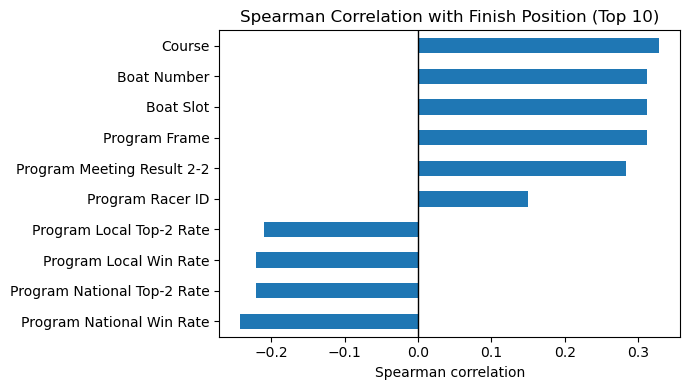

In [9]:
import matplotlib.pyplot as plt

feature_name_map = {
    'レース場': 'Venue',
    'レース回_num': 'Race Number',
    '風速(m)': 'Wind Speed (m/s)',
    '風向': 'Wind Direction',
    '波の高さ(cm)': 'Wave Height (cm)',
    '天候': 'Weather',
    '気温(℃)': 'Air Temp (C)',
    '水温(℃)': 'Water Temp (C)',
    '艇': 'Boat Slot',
    '艇番': 'Boat Number',
    'コース': 'Course',
    '体重(kg)': 'Weight (kg)',
    '体重調整(kg)': 'Weight Adjust (kg)',
    '展示タイム': 'Exhibition Time',
    'チルト調整': 'Tilt Adjust',
    'スタート展示': 'Start Timing (Exhibition)',
    '番組_距離(m)': 'Program Distance (m)',
    '番組_枠': 'Program Frame',
    '番組_登録番号': 'Program Racer ID',
    '番組_年齢': 'Program Age',
    '番組_体重': 'Program Weight',
    '番組_全国勝率': 'Program National Win Rate',
    '番組_全国2連対率': 'Program National Top-2 Rate',
    '番組_当地勝率': 'Program Local Win Rate',
    '番組_当地2連対率': 'Program Local Top-2 Rate',
    '番組_モーター番号': 'Program Motor Number',
    '番組_モーター2連対率': 'Program Motor Top-2 Rate',
    '番組_ボート番号': 'Program Boat Number',
    '番組_ボート2連対率': 'Program Boat Top-2 Rate',
}

def format_feature_name(name):
    if name.startswith('番組_今節成績_'):
        suffix = name.split('_')[-1]
        return f'Program Meeting Result {suffix}'
    return feature_name_map.get(name, str(name))

top = corr.dropna().head(10).sort_values('spearman')
top = top.copy()
top.index = [format_feature_name(name) for name in top.index]

ax = top['spearman'].plot(
    kind='barh',
    figsize=(7, 4),
    title='Spearman Correlation with Finish Position (Top 10)',
)
ax.axvline(0, color='black', linewidth=1)
ax.set_xlabel('Spearman correlation')
plt.tight_layout()


次の一歩(特徴量エンジニアリングの例):
- レース内での相対値(展示タイムの平均との差や順位)を作る。
- 風向×コース、艇番×コースなどの交互作用を試す。
- コース別のスタート展示平均との差を使う。
